In [1]:
import importlib
import moment_kernels as mk
importlib.reload(mk)
import torch
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
from sklearn.metrics import accuracy_score
import medmnist

In [2]:
dataset = CIFAR10('/home/dtward/data',transform=ToTensor())
dataset_test = CIFAR10('/home/dtward/data',transform=ToTensor(),train=False)

In [3]:
dataset = medmnist.BloodMNIST(transform=ToTensor(),split='train')
dataset_test = medmnist.BloodMNIST(transform=ToTensor(),split='test')

In [4]:
loader = torch.utils.data.DataLoader(dataset,batch_size=32,shuffle=True)
loader_test = torch.utils.data.DataLoader(dataset_test,batch_size=32)

In [5]:
for x,l in loader:
    break
fig,ax = plt.subplots()
ax.imshow(x[0].permute(1,2,0))
ax.set_title(f'{l[0]}')

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'tensor([0])')

In [6]:
class Net(torch.nn.Module):
    def __init__(self,):
        super().__init__()
        
        channels0 = 8
        kernel_size = 3
        padding = 1
        out_channels = 10
        # build a convolution layer
        # that takes 3 scalar images and 0 vector images as input (3 channels total)
        # and it will output 8 scalar images, and 8 vector images (8+8*2=24 channels total)
        # convention: at every layer, we will use the same number of scalar and vector channels
        # to map from a scalar to a scalar it uses a kernel of the form f(|x|)
        # to map from scalar to vector it uses a kernel of the form f(|x|)x
        # to map from vector to scalar it uses a kernel of the form f(|x|)x^T
        # to map from vector to vector it uses a kernel of the form f_1(|x|)id + f_2(|x|)xx^T
        # in this example, we will use 8x3 kernels of the form f(|x|) 
        # each scalar channel in the input is coupled to each scalar channel in the output with one convolution
        # and we will use 8x3 kernels of the form f(|x|)x
        # each scalar channel in the input is coupled to each vector channel in the output with one convolution
        
        # for a more specific example, let's say there were 3 input scalars, and 2 output scalars and 2 output vectors
        #
        # say I_i(x) is the ith of 3 scalar channels in the input image (i=1 means red, 2 means green 3 means blue)
        # and Js_j(x) is the jth of 2 scalar channels in the output image
        # and Jv_j(x) is the jth of 2 vector channels in the output image
        # the equation is, kernels are f_ij
        # Js_1(x) = int f_11(|x-x'|)I_1(x') dx' + int f_12(|x-x'|)I_2(x')dx' + int f_13(|x-x'|)I_3(x')dx'
        # Js_2(x) = int f_21(|x-x'|)I_1(x') dx' + int f_22(|x-x'|)I_2(x')dx' + int f_23(|x-x'|)I_3(x')dx'        
        # for the vector part, kernels are g_ij
        # Jv_1(x) = int g_11(|x-x'|)(x-x')I_1(x')dx' 
        #         + int g_12(|x-x'|)(x-x')I_2(x')dx' 
        #         + int g_13(|x-x'|)(x-x')I_3(x')dx'
        # note that Jv_1 has two components (x and y)
        # Jv_2(x) = int g_21(|x-x'|)(x-x')I_1(x')dx' 
        #         + int g_22(|x-x'|)(x-x')I_2(x')dx' 
        #         + int g_23(|x-x'|)(x-x')I_3(x')dx'
        # note Jv_2 also has two components
        # the last thing the layer does is stack them on top of each other
        # so J = [Js,Jv] # stacked on top
        # so theres a total of 24 channels (8 scalars, 8 vector x components, and 8 vector y components)
        # 
        # how would you do the same thing in ecnn framework
        # input_field_type = [trial]*3
        # output_field_type = [trivial]*2 + [irreducible]*2
        # I think this would be equivalent
        self.c0 = mk.ScalarVectorToScalarVector(in_scalars=3,in_vectors=0,out_scalars=channels0,out_vectors=channels0, kernel_size=kernel_size, padding=1)
        self.b0 = mk.ScalarVectorBatchnorm(channels0,channels0)
        self.s0 = mk.ScalarVectorSigmoid(channels0)
        
        self.c1 = mk.ScalarVectorToScalarVector(in_scalars=channels0,in_vectors=channels0,out_scalars=channels0*2,out_vectors=channels0*2,kernel_size=kernel_size,padding=padding)
        self.d1 = mk.Downsample()
        self.b1 = mk.ScalarVectorBatchnorm(channels0*2,channels0*2)
        self.s1 = mk.ScalarVectorSigmoid(channels0*2)
        
        self.c2 = mk.ScalarVectorToScalarVector(in_scalars=channels0*2,in_vectors=channels0*2,out_scalars=channels0*4,out_vectors=channels0*4,kernel_size=kernel_size,padding=padding)
        self.d2 = mk.Downsample()
        self.b2 = mk.ScalarVectorBatchnorm(channels0*4,channels0*4)
        self.s2 = mk.ScalarVectorSigmoid(channels0*4)
        
        self.c3 = mk.ScalarVectorToScalarVector(in_scalars=channels0*4,in_vectors=channels0*4,out_scalars=channels0*8,out_vectors=channels0*8,kernel_size=kernel_size,padding=padding)
        self.d3 = mk.Downsample()
        self.b3 = mk.ScalarVectorBatchnorm(channels0*8,channels0*8)
        self.s3 = mk.ScalarVectorSigmoid(channels0*8)
        
        self.c4 = mk.ScalarVectorToScalarVector(in_scalars=channels0*8,in_vectors=channels0*8,out_scalars=channels0*16,out_vectors=channels0*16,kernel_size=kernel_size,padding=padding)
        self.d4 = mk.Downsample()
        self.b4 = mk.ScalarVectorBatchnorm(channels0*16,channels0*16)
        self.s4 = mk.ScalarVectorSigmoid(channels0*16)
        
        self.c5 = mk.ScalarVectorToScalarVector(in_scalars=channels0*16,in_vectors=channels0*16,out_scalars=out_channels,out_vectors=0,kernel_size=kernel_size,padding=padding)
        self.d5 = mk.Downsample()
        
        
        
        
        
    def forward(self,x):
        x = self.c0(x)
        x = self.b0(x)
        x = self.s0(x)
        
        x = self.c1(x)
        x = self.d1(x)
        x = self.b1(x)
        x = self.s1(x)
        
        x = self.c2(x)
        x = self.d2(x)
        x = self.b2(x)
        x = self.s2(x)
        
        x = self.c3(x)
        x = self.d3(x)
        x = self.b3(x)
        x = self.s3(x)
        
        x = self.c4(x)
        x = self.d4(x)
        x = self.b4(x)
        x = self.s4(x)
        
        # last time no nonlinearity
        x = self.c5(x)
        x = self.d5(x)
        
        # average out any spatial dimensions
        x = torch.mean(x,(-1,-2))
        
        
        return x

In [7]:
net = Net()
count = 0
for p in net.parameters():
    count += p.numel()
print(f'{count} parameters')

138580 parameters


In [8]:
net(x).shape

torch.Size([32, 10])

In [9]:
kernel = net.c1.vv.c

In [10]:
# there are 16 input channels (8 vectors)
# there are 32 output channels (16 vectors)
# for each row/col, we can divide it into 2x2 blocks
# we take a bunch of 2x2 blocks, and stack them together to use pytorch's built in conv function.
kernel.shape

torch.Size([32, 16, 3, 3])

In [11]:
kernel[:2,:2,1,1] # note this is proportional to identity, times -0.2

tensor([[-0.0452, -0.0000],
        [-0.0000, -0.0452]], grad_fn=<SelectBackward0>)

In [12]:
kernel[:2,:2,1,0] # not proportional to identity, because it has the xx^T and id mixed together

tensor([[ 0.0941,  0.0000],
        [ 0.0000, -0.0353]], grad_fn=<SelectBackward0>)

In [13]:
kernel[:2,:2,0,0] # as we look at different rows and columns we see different numbers

tensor([[0.0356, 0.0123],
        [0.0123, 0.0356]], grad_fn=<SelectBackward0>)

In [14]:
kernel[:2,:2,1,2] # note that this is evaluated at x=(0,1), the previous was y=(0,-1)= -x

tensor([[ 0.0941,  0.0000],
        [ 0.0000, -0.0353]], grad_fn=<SelectBackward0>)

In [15]:
# there is a matrix valued function for each row and column (row/column = "location x")
# the components are not independent of one another, 
# they depend on one another in a predictable way as a function of space

In [16]:
# check the equivariance
with torch.no_grad():
    err = net(x) - net(x.rot90(k=1,dims=(-1,-2)))
    print(torch.sqrt(torch.mean(err**2)).item())
    
    err = net(x) - net(x.flip(dims=(-1,)))
    print(torch.sqrt(torch.mean(err**2)).item())

6.811258117522812e-07
6.164677870401647e-07


In [17]:
lr = 1e-4
optimizer = torch.optim.Adam(net.parameters(),lr=lr)
loss = torch.nn.CrossEntropyLoss()

In [18]:
class Net1(torch.nn.Module):
    def __init__(self,channels0):
        super().__init__()
        
        #channels0 = 16
        kernel_size = 3
        padding = 1
        out_channels = 10
        self.c0 = torch.nn.Conv2d(3,channels0,kernel_size=kernel_size,padding=1)
        self.b0 = torch.nn.BatchNorm2d(channels0)
        self.s0 = torch.nn.ReLU()
        
        self.c1 = torch.nn.Conv2d(channels0,channels0*2,kernel_size=kernel_size,padding=padding,stride=2)
        self.b1 = torch.nn.BatchNorm2d(channels0*2)
        self.s1 = torch.nn.ReLU()
        
        self.c2 = torch.nn.Conv2d(channels0*2,channels0*4,kernel_size=kernel_size,padding=padding,stride=2)
        self.b2 = torch.nn.BatchNorm2d(channels0*4)
        self.s2 = torch.nn.ReLU()
        
        self.c3 = torch.nn.Conv2d(channels0*4,channels0*8,kernel_size=kernel_size,padding=padding,stride=2)
        self.b3 = torch.nn.BatchNorm2d(channels0*8)
        self.s3 = torch.nn.ReLU()
        
        self.c4 = torch.nn.Conv2d(channels0*8,channels0*16,kernel_size=kernel_size,padding=padding,stride=2)
        self.b4 = torch.nn.BatchNorm2d(channels0*16)
        self.s4 = torch.nn.ReLU()
        
        self.c5 = torch.nn.Conv2d(channels0*16,out_channels,kernel_size=kernel_size,padding=padding,stride=2)
        
        
        
        
        
    def forward(self,x):
        x = self.c0(x)
        x = self.b0(x)
        x = self.s0(x)
        
        x = self.c1(x)        
        x = self.b1(x)
        x = self.s1(x)
        
        x = self.c2(x)        
        x = self.b2(x)
        x = self.s2(x)
        
        x = self.c3(x)        
        x = self.b3(x)
        x = self.s3(x)
        
        x = self.c4(x)        
        x = self.b4(x)
        x = self.s4(x)
        
        # last time no nonlinearity
        x = self.c5(x)        
        
        # average out any spatial dimensions
        x = torch.mean(x,(-1,-2))
        
        
        return x

In [19]:
# about the same number of parameters
net1 = Net1(9)
count = 0
for p in net1.parameters():
    count += p.numel()
print(f'{count} parameters')

137980 parameters


In [20]:
optimizer1 = torch.optim.Adam(net1.parameters(),lr=lr)

<IPython.core.display.Javascript object>


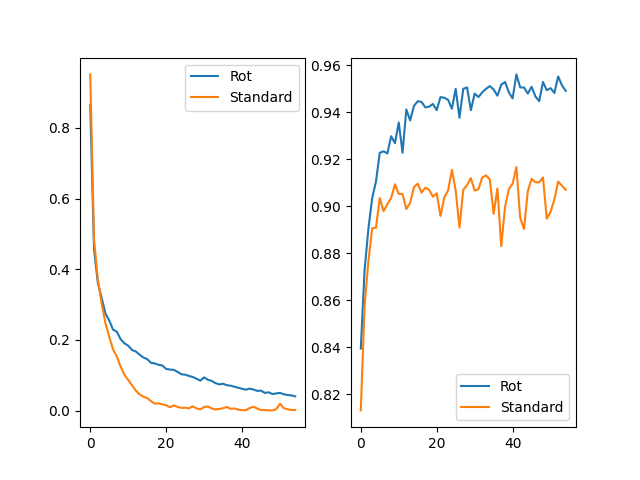

/home/dtward/.local/intelpython3/lib/python3.7/site-packages/torch/autograd/__init__.py:199: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to run the backward pass


In [ ]:

nepochs = 100
Esave = []
E1save = []
accuracysave = []
accuracy1save = []
fig,ax = plt.subplots(1,2)
for e in range(nepochs):
    E_ = []
    E1_ = []
    count = 0
    for x,l in loader:
        optimizer.zero_grad()
        lhat = net(x)
        E = loss(lhat,l.squeeze())
        E.backward()
        optimizer.step()
        E_.append(E.item())
        
        optimizer1.zero_grad()
        lhat = net1(x)
        E = loss(lhat,l.squeeze())
        E.backward()
        optimizer1.step()
        E1_.append(E.item())
        
        
        if count > 100000000: 
            break # stop early for this example
        count += 1
    Esave.append(np.mean(E_))
    E1save.append(np.mean(E1_))
    ax[0].cla()
    ax[0].plot(Esave,label='Rot')
    ax[0].plot(E1save,label='Standard')
    ax[0].legend()
    
    
    with torch.no_grad():
        net.train(False)
        net1.train(False)
        ltrue = []
        lhat = []
        lhat1 = []
        for x,l in loader_test:
            lhat.append(net(x))
            lhat1.append(net1(x))        

            ltrue.append(l)
        net.train(True)
        net1.train(True)
        
    rotaccuracy = accuracy_score(torch.concatenate(ltrue),torch.argmax(torch.concatenate(lhat) ,-1) )
    standard_accuracy = accuracy_score(torch.concatenate(ltrue),torch.argmax(torch.concatenate(lhat1) ,-1) )
    accuracysave.append(rotaccuracy)
    accuracy1save.append(standard_accuracy)

    ax[1].cla()
    ax[1].plot(accuracysave,label='Rot')
    ax[1].plot(accuracy1save,label='Standard')
    ax[1].legend()
    fig.canvas.draw()
    
    

In [ ]:
lhat.shape,l.shape

In [ ]:
net.train(False)

In [ ]:
net(x)[0],net1(x)[0]

In [ ]:
fig,ax = plt.subplots()
ax.imshow(x[0].permute(1,2,0))